# Parser Teks Dokumen dan Pengekstrak Kata Kunci Keuangan (Tahunan)

Notebook ini bertujuan untuk mem-parsing teks dari berbagai jenis dokumen (gambar, TXT, DOCX, PDF) dan kemudian mengekstrak istilah-istilah keuangan spesifik beserta nilainya, dengan fokus pada **data tahun pelaporan terbaru**. Proses ini melibatkan beberapa teknologi dan fitur utama:
- **OCR (Optical Character Recognition)**: Untuk mengekstrak teks dari gambar dan PDF berbasis gambar.
- **Pra-pemrosesan Gambar**: Sebelum OCR, gambar diproses melalui beberapa tahap (konversi ke skala abu, penghilangan derau, binerisasi, dan percobaan pelurusan kemiringan) untuk meningkatkan kualitas OCR.
- **Pemrosesan Paralel untuk PDF**: Halaman PDF yang memerlukan OCR diproses secara paralel untuk mempercepat ekstraksi.
- **Mekanisme Caching**: Hasil parsing PDF disimpan dalam cache untuk menghindari pemrosesan ulang file yang sama jika tidak ada perubahan.
- **Ekstraksi Kata Kunci Bertarget**: Mencari istilah keuangan yang telah ditentukan (dalam Bahasa Indonesia) dan mencoba mengidentifikasi nilai numerik yang berasosiasi dengan tahun pelaporan terbaru yang terdeteksi dalam dokumen.
- **Normalisasi Nilai**: Nilai keuangan yang diekstrak dinormalisasi ke format float.
- **Output JSON**: Hasil akhir ekstraksi kata kunci dan nilainya disajikan dalam format JSON.

Pastikan semua skrip Python pendukung (`parser_gambar.py`, `parser_dokumen_teks.py`, `parser_pdf.py`, `pengekstrak_kata_kunci.py`, `utilitas_cache.py`) berada di direktori yang sama dengan notebook ini atau terinstal dalam lingkungan Python Anda.


In [6]:
# Langkah Pengaturan Awal

# 1. Impor Pustaka dan Modul Kustom
# Pastikan semua skrip Python (.py) yang disebutkan di bawah ini
# berada di direktori yang sama dengan notebook ini.

import os
import json
import nltk

# Impor fungsi-fungsi dari modul-modul utilitas kita
try:
    from SaranaModule.parser_gambar import ekstrak_teks_dari_gambar
    from SaranaModule.parser_dokumen_teks import ekstrak_teks_dari_txt, ekstrak_teks_dari_docx
    from SaranaModule.parser_pdf import ekstrak_teks_dari_pdf # Fungsi ini menggunakan ekstrak_teks_dari_gambar untuk OCR
    from SaranaModule.parser_tabular import ekstrak_data_dari_xlsx, ekstrak_data_dari_csv
    from SaranaModule.pengekstrak_kata_kunci import (
        DAFTAR_KATA_KUNCI_KEUANGAN_DEFAULT, # Daftar kata kunci default
        identifikasi_tahun_pelaporan,       # Untuk menemukan tahun dalam dokumen
        ekstrak_data_keuangan_tahunan,      # Fungsi ekstraksi utama yang baru
        format_ke_json,                     # Untuk output JSON
        normalisasi_nilai_keuangan,          # Untuk membersihkan nilai angka (jika ingin diuji terpisah)
        deteksi_pengali_global              # Untuk mendeteksi pengali global seperti 'juta', 'miliar', dll.
    )
    print("Modul-modul kustom berhasil diimpor.")
except ImportError as e:
    print(f"Error mengimpor modul kustom: {e}")
    print("Pastikan semua file .py (parser_gambar, parser_dokumen_teks, parser_pdf, pengekstrak_kata_kunci, utilitas_cache) berada di direktori yang sama.")


try:
    nltk.data.find('corpora/wordnet.zip')
    print("Resource NLTK (wordnet) sudah ada.")
except LookupError:
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    print("Resource NLTK (wordnet) tidak ditemukan, mengunduh...")
    nltk.download('wordnet')
    nltk.download('punkt_tab')
    nltk.download('omw-1.4') # wordnet multilingual
    nltk.download('punkt')   # untuk tokenisasi
    nltk.download('stopwords') # untuk stopwords
    print("Resource NLTK (wordnet) sudah terunduh.")

except Exception as e:
     print(f"Error terkait NLTK: {e}")

print("\nPengaturan Selesai. Anda dapat melanjutkan ke sel Konfigurasi.")

Modul-modul kustom berhasil diimpor.
Resource NLTK (wordnet) sudah ada.

Pengaturan Selesai. Anda dapat melanjutkan ke sel Konfigurasi.


## Penjelasan Fitur Utama

Sebelum melanjutkan ke konfigurasi, berikut adalah ringkasan singkat tentang beberapa fitur utama yang digunakan dalam notebook ini:

*   **Pra-pemrosesan Gambar untuk OCR**: Jika dokumen Anda adalah gambar atau PDF yang berisi halaman gambar, kualitas OCR sangat penting. Modul `parser_gambar.py` kini menyertakan langkah-langkah seperti konversi ke skala abu, penghilangan derau (noise), dan binerisasi (mengubah gambar menjadi hitam-putih) untuk meningkatkan akurasi Tesseract OCR. Implementasi dasar untuk pelurusan kemiringan (deskewing) juga ada, meskipun mungkin memerlukan penyesuaian lebih lanjut untuk kasus yang kompleks.
*   **Pemrosesan Paralel untuk PDF**: Untuk mempercepat ekstraksi teks dari PDF yang memiliki banyak halaman berbasis gambar (yang memerlukan OCR), `parser_pdf.py` menggunakan `ThreadPoolExecutor`. Ini memungkinkan beberapa halaman diproses secara bersamaan, mengurangi waktu tunggu total.
*   **Caching Hasil Parsing**: Untuk menghindari pemrosesan ulang file PDF yang sama berulang kali (yang bisa memakan waktu), `parser_pdf.py` kini terintegrasi dengan mekanisme caching (`utilitas_cache.py`). Hasil ekstraksi teks dari sebuah PDF akan disimpan dalam cache (default di direktori `.cache_parser_dokumen`). Jika Anda memproses PDF yang sama lagi dan file tersebut tidak berubah (berdasarkan path dan timestamp modifikasi terakhir), hasilnya akan diambil dari cache, yang jauh lebih cepat. Anda bisa membersihkan cache ini secara manual atau menggunakan fungsi `bersihkan_cache_lama` (jika ingin diimplementasikan lebih lanjut).
*   **Logika Ekstraksi Nilai Berbasis Tahun**: Fungsi `ekstrak_data_keuangan_tahunan` dalam `pengekstrak_kata_kunci.py` dirancang untuk pertama-tama mengidentifikasi tahun pelaporan utama dalam dokumen. Kemudian, saat mencari nilai untuk kata kunci keuangan, ia akan mencoba memprioritaskan angka yang berasosiasi dengan tahun pelaporan tersebut dan membedakannya dari angka untuk tahun sebelumnya, jika keduanya muncul berdekatan.


In [7]:
# --- Konfigurasi Pengguna ---

# 1. Tentukan path ke DIREKTORI yang berisi dokumen yang ingin Anda proses.
# Contoh: "train_documents/" untuk data periode t, atau "train_documents_t_minus_1/" untuk data periode t-1.
path_direktori_dokumen_input = "train_documents/"

# 2. Tentukan nama file JSON output untuk menyimpan hasil ekstraksi.
# Contoh: "hasil_ekstraksi_semua_dokumen.json" untuk periode t,
#         "hasil_ekstraksi_semua_dokumen_t_minus_1.json" untuk periode t-1.
nama_file_json_output = "hasil_ekstraksi_semua_dokumen.json"
# Direktori output akan tetap "OutputSarana/" secara default, jadi path lengkapnya akan menjadi "OutputSarana/nama_file_json_output".

# 3. Definisikan atau Modifikasi Kata Kunci yang Akan Diekstrak
# `konfigurasi_kata_kunci_target` adalah list kamus (dictionary).
# Setiap kamus harus memiliki:
#    - 'kata_dasar': Nama kanonis untuk kata kunci tersebut (misalnya, "Laba Bersih"). Ini akan menjadi kunci dalam output JSON.
#    - 'variasi': List berisi berbagai cara penulisan atau sinonim kata kunci tersebut yang mungkin muncul di dokumen.
#
# Anda bisa menggunakan daftar default yang diimpor (`DAFTAR_KATA_KUNCI_KEUANGAN_DEFAULT`)
# atau membuat/memodifikasi daftar Anda sendiri di bawah ini.
#
# Untuk menggunakan daftar default:
from SaranaModule.pengekstrak_kata_kunci import DAFTAR_KATA_KUNCI_KEUANGAN_DEFAULT
konfigurasi_kata_kunci_target = DAFTAR_KATA_KUNCI_KEUANGAN_DEFAULT

# 3. (Opsional) Konfigurasi Direktori Cache untuk PDF Parser
# Jika Anda ingin parser PDF menggunakan direktori cache selain default (`.cache_parser_dokumen`),
# Anda bisa menentukan path-nya di sini. Jika tidak, biarkan `None` untuk menggunakan default.
direktori_cache_pdf_kustom = ".cache_parsing_dokumen"

# --- Akhir Konfigurasi Pengguna ---

# Validasi awal konfigurasi
if 'path_direktori_dokumen_input' not in locals() or not path_direktori_dokumen_input:
    print("PERINGATAN: 'path_direktori_dokumen_input' belum diatur atau kosong.")
    print("Mohon perbarui variabel 'path_direktori_dokumen_input' di atas dengan path ke DIREKTORI yang berisi dokumen-dokumen yang ingin Anda proses.")
elif not os.path.isdir(path_direktori_dokumen_input):
    print(f"ERROR: Path direktori input yang ditentukan ('{path_direktori_dokumen_input}') bukan direktori atau tidak ditemukan.")
    print("Mohon periksa kembali 'path_direktori_dokumen_input' dan pastikan itu adalah direktori yang valid dan ada.")
elif 'nama_file_json_output' not in locals() or not nama_file_json_output:
    print("PERINGATAN: 'nama_file_json_output' belum diatur atau kosong.")
    print("Mohon perbarui variabel 'nama_file_json_output' untuk menentukan nama file hasil ekstraksi.")
else:
    print(f"Konfigurasi dimuat. Direktori dokumen yang akan diproses: {path_direktori_dokumen_input}")
    print(f"Hasil ekstraksi akan disimpan ke: OutputSarana/{nama_file_json_output}")
    print(f"Kata kunci yang akan dicari: {[item['kata_dasar'] for item in konfigurasi_kata_kunci_target]}")
    if direktori_cache_pdf_kustom:
        print(f"Direktori cache PDF kustom diatur ke: {direktori_cache_pdf_kustom}")

# Inisialisasi list untuk menyimpan semua hasil ekstraksi dari semua dokumen
semua_hasil_ekstraksi = []


Konfigurasi dimuat. Direktori dokumen yang akan diproses: train_documents/
Hasil ekstraksi akan disimpan ke: OutputSarana/hasil_ekstraksi_semua_dokumen.json
Kata kunci yang akan dicari: ['Jumlah aset lancar', 'Jumlah aset tidak lancar', 'Jumlah liabilitas jangka pendek', 'Jumlah liabilitas jangka panjang', 'Jumlah ekuitas', 'Jumlah liabilitas dan ekuitas', 'Pendapatan bersih', 'Beban pokok pendapatan', 'Laba bruto', 'Laba sebelum pajak penghasilan', 'Beban pajak penghasilan', 'Laba tahun berjalan', 'Jumlah aset', 'Piutang Usaha', 'Aset Tetap', 'Aset Tetap Bruto', 'Akumulasi Penyusutan', 'Modal Kerja Bersih', 'Jumlah liabilitas', 'Laba ditahan', 'Beban bunga', 'Beban penyusutan', 'Beban penjualan', 'Beban administrasi dan umum', 'Beban usaha', 'Arus kas bersih yang diperoleh dari aktivitas operasi', 'Arus kas bersih yang diperoleh dari aktivitas investasi', 'Arus kas bersih yang digunakan untuk aktivitas pendanaan', 'Piutang usaha tahun lalu', 'Pendapatan bersih tahun lalu', 'Laba kotor

In [8]:
# Langkah ini akan melakukan iterasi melalui semua dokumen yang didukung dalam direktori yang ditentukan,
# mengekstrak teks dari masing-masing dokumen, dan kemudian mengekstrak kata kunci.

# Pastikan path_direktori_dokumen_input (direktori) telah dikonfigurasi dengan benar dan merupakan direktori
if 'path_direktori_dokumen_input' not in locals() or not path_direktori_dokumen_input or not os.path.isdir(path_direktori_dokumen_input) or \
   'nama_file_json_output' not in locals() or not nama_file_json_output:
    pesan_error_global = "Error: Konfigurasi 'path_direktori_dokumen_input' atau 'nama_file_json_output' tidak valid. Silakan perbarui di sel Konfigurasi."
    if 'path_direktori_dokumen_input' in locals() and (not path_direktori_dokumen_input):
        pesan_error_global = "Error: 'path_direktori_dokumen_input' (direktori) belum diatur atau kosong. Silakan perbarui di sel Konfigurasi."
    elif 'path_direktori_dokumen_input' in locals() and not os.path.isdir(path_direktori_dokumen_input):
        pesan_error_global = f"Error: Path '{path_direktori_dokumen_input}' bukan direktori yang valid atau tidak ditemukan. Mohon verifikasi path di sel Konfigurasi."
    elif 'nama_file_json_output' not in locals() or not nama_file_json_output:
        pesan_error_global = "Error: 'nama_file_json_output' belum diatur atau kosong. Silakan perbarui di sel Konfigurasi."
    
    print(pesan_error_global)
    if 'semua_hasil_ekstraksi' not in locals(): 
        semua_hasil_ekstraksi = [] 
    semua_hasil_ekstraksi.append({
        "nama_file": "KONFIGURASI_ERROR",
        "hasil_ekstraksi": {"error_global_konfigurasi": pesan_error_global}
    })
else:
    supported_extensions = ['.pdf', '.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.gif', '.txt', '.docx', '.xlsx', '.csv']
    print(f"Mencari dokumen dengan ekstensi yang didukung: {', '.join(supported_extensions)} di direktori: {path_direktori_dokumen_input}")
    
    files_to_process = []
    try:
        files_to_process = [
            f for f in os.listdir(path_direktori_dokumen_input) 
            if os.path.isfile(os.path.join(path_direktori_dokumen_input, f)) and 
            os.path.splitext(f)[1].lower() in supported_extensions
        ]
    except FileNotFoundError:
        print(f"Error: Direktori '{path_direktori_dokumen_input}' tidak ditemukan. Periksa konfigurasi path_direktori_dokumen_input.")
        if 'semua_hasil_ekstraksi' not in locals(): semua_hasil_ekstraksi = []
        semua_hasil_ekstraksi.append({"nama_file": "DIREKTORI_TIDAK_DITEMUKAN", "hasil_ekstraksi": {"error_direktori": f"Direktori '{path_direktori_dokumen_input}' tidak ditemukan."}})
    except Exception as e_listdir:
        print(f"Error saat mengakses direktori '{path_direktori_dokumen_input}': {e_listdir}")
        if 'semua_hasil_ekstraksi' not in locals(): semua_hasil_ekstraksi = []
        semua_hasil_ekstraksi.append({"nama_file": "AKSES_DIREKTORI_ERROR", "hasil_ekstraksi": {"error_direktori": f"Error mengakses '{path_direktori_dokumen_input}': {e_listdir}"}})

    if not files_to_process:
        msg_no_files = f"Tidak ada dokumen dengan ekstensi yang didukung ditemukan di {path_direktori_dokumen_input}"
        print(msg_no_files)
        if not any(d.get("nama_file") in ["KONFIGURASI_ERROR", "DIREKTORI_TIDAK_DITEMUKAN", "AKSES_DIREKTORI_ERROR"] for d in semua_hasil_ekstraksi):
            if 'semua_hasil_ekstraksi' not in locals(): semua_hasil_ekstraksi = []
            semua_hasil_ekstraksi.append({"nama_file": "TIDAK_ADA_FILE", "hasil_ekstraksi": {"info": msg_no_files}})
    else:
        print(f"Ditemukan {len(files_to_process)} dokumen untuk diproses: {files_to_process}")

        for nama_file_dokumen in files_to_process:
            current_file_path = os.path.join(path_direktori_dokumen_input, nama_file_dokumen)
            print(f"\n--- Memulai pemrosesan untuk dokumen: {nama_file_dokumen} ---")
            
            teks_hasil_ekstraksi_file = "" # Inisialisasi untuk setiap file
            kamus_hasil_ekstraksi_file = {} # Inisialisasi untuk setiap file
            
            ekstensi_file = os.path.splitext(nama_file_dokumen)[1].lower()
            print(f"Tipe berkas terdeteksi: {ekstensi_file} untuk {nama_file_dokumen}")

            try:
                if ekstensi_file == '.pdf':
                    dir_cache = direktori_cache_pdf_kustom if 'direktori_cache_pdf_kustom' in locals() and direktori_cache_pdf_kustom else None
                    teks_hasil_ekstraksi_file = ekstrak_teks_dari_pdf(current_file_path, ekstrak_teks_dari_gambar, direktori_cache_kustom=dir_cache)
                elif ekstensi_file in ['.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.gif']:
                    teks_hasil_ekstraksi_file = ekstrak_teks_dari_gambar(current_file_path)
                elif ekstensi_file == '.xlsx':
                    teks_hasil_ekstraksi_file = ekstrak_data_dari_xlsx(current_file_path)
                elif ekstensi_file == '.csv':
                    teks_hasil_ekstraksi_file = ekstrak_data_dari_csv(current_file_path)
                elif ekstensi_file == '.txt':
                    teks_hasil_ekstraksi_file = ekstrak_teks_dari_txt(current_file_path)
                elif ekstensi_file == '.docx':
                    teks_hasil_ekstraksi_file = ekstrak_teks_dari_docx(current_file_path)
                # Tidak perlu klausa else karena sudah difilter oleh supported_extensions
            
            except Exception as e_parse:
                error_msg_parse = f"Error selama parsing dokumen '{nama_file_dokumen}': {str(e_parse)}"
                print(error_msg_parse)
                teks_hasil_ekstraksi_file = error_msg_parse # Simpan error di sini untuk di-log

            # Lanjutkan ke ekstraksi kata kunci jika parsing berhasil dan menghasilkan teks
            if not teks_hasil_ekstraksi_file.startswith("Error:") and teks_hasil_ekstraksi_file.strip():
                print(f"Parsing dokumen '{nama_file_dokumen}' selesai. Total karakter: {len(teks_hasil_ekstraksi_file)}")
                # print(f"Cuplikan: {teks_hasil_ekstraksi_file[:200]}...") # Opsional: cuplikan per file
                
                # --- Logika Ekstraksi Kata Kunci (dari sel c87d8344) dipindahkan ke sini ---
                print(f"Memulai ekstraksi kata kunci untuk: {nama_file_dokumen}")
                pengali_dokumen_file = 1.0 # Default pengali
                print_output_pengali_file = []

                try:
                    pengali_dokumen_file = deteksi_pengali_global(teks_hasil_ekstraksi_file)
                    print_output_pengali_file.append(f"Pengali terdeteksi untuk '{nama_file_dokumen}': {pengali_dokumen_file}")
                except Exception as e_pengali:
                    print_output_pengali_file.append(f"Error saat deteksi pengali untuk '{nama_file_dokumen}': {str(e_pengali)}. Menggunakan default 1.0.")
                    pengali_dokumen_file = 1.0
                
                for msg in print_output_pengali_file: print(msg) # Cetak log pengali
                    
                if 'konfigurasi_kata_kunci_target' not in locals() or not konfigurasi_kata_kunci_target:
                    pesan_error_konfig_loop = "Error krusial: 'konfigurasi_kata_kunci_target' tidak terdefinisi. Periksa sel Konfigurasi."
                    print(pesan_error_konfig_loop)
                    kamus_hasil_ekstraksi_file = {"error_konfigurasi_global": pesan_error_konfig_loop}
                else:
                    try:
                        kamus_hasil_ekstraksi_file = ekstrak_data_keuangan_tahunan(
                            teks_hasil_ekstraksi_file, 
                            konfigurasi_kata_kunci_target, 
                            pengali_global=pengali_dokumen_file
                        )
                        print(f"Ekstraksi kata kunci untuk '{nama_file_dokumen}' selesai.")
                        # Opsional: Tampilkan hasil per file
                        # if kamus_hasil_ekstraksi_file:
                        #     for k, v in kamus_hasil_ekstraksi_file.items():
                        #         print(f"  - {k}: {v if v is not None else 'Tidak ditemukan'}")
                        # else:
                        #     print(f"  Tidak ada kata kunci yang ditemukan atau diekstrak untuk '{nama_file_dokumen}'.")
                    except Exception as e_ekstraksi:
                        pesan_error_ekstraksi_loop = f"Error selama proses ekstraksi kata kunci untuk '{nama_file_dokumen}': {str(e_ekstraksi)}"
                        print(pesan_error_ekstraksi_loop)
                        kamus_hasil_ekstraksi_file = {"error_runtime_ekstraksi": pesan_error_ekstraksi_loop}
                # --- Akhir Logika Ekstraksi Kata Kunci ---

            elif not teks_hasil_ekstraksi_file.strip() and not teks_hasil_ekstraksi_file.startswith("Error:"):
                info_msg = f"Info: Teks yang diekstrak dari '{nama_file_dokumen}' kosong atau hanya spasi putih."
                print(info_msg)
                kamus_hasil_ekstraksi_file = {"info_parsing": info_msg} # Log info ini
            else: # Ada error dari parsing (teks_hasil_ekstraksi_file sudah berisi pesan error)
                # Pesan error sudah dicetak saat parsing gagal
                kamus_hasil_ekstraksi_file = {"error_parsing": teks_hasil_ekstraksi_file}

            # Simpan hasil untuk file ini (meskipun ada error, simpan informasinya)
            semua_hasil_ekstraksi.append({
                "nama_file": nama_file_dokumen,
                "hasil_ekstraksi": kamus_hasil_ekstraksi_file
            })
            print(f"--- Pemrosesan untuk dokumen: {nama_file_dokumen} selesai. Hasil disimpan. ---")
            
        print("\n=== Semua dokumen dalam direktori telah diproses. ===")

# Ringkasan setelah loop selesai
if 'semua_hasil_ekstraksi' in locals() and semua_hasil_ekstraksi:
    print(f"Total item dalam 'semua_hasil_ekstraksi': {len(semua_hasil_ekstraksi)} (termasuk potensi pesan error global atau info tidak ada file)")
    for hasil_item in semua_hasil_ekstraksi:
        status = "Sukses"
        if isinstance(hasil_item['hasil_ekstraksi'], dict) and any(k.startswith('error') for k in hasil_item['hasil_ekstraksi'].keys()):
            status = "Error"
        elif not hasil_item['hasil_ekstraksi']:
            status = "Kosong/Tidak ada data"
        print(f"  Dokumen: {hasil_item['nama_file']}, Status Ekstraksi: {status}")
else:
    print("Tidak ada hasil ekstraksi yang tersimpan atau 'semua_hasil_ekstraksi' kosong. Periksa log di atas.")


Mencari dokumen dengan ekstensi yang didukung: .pdf, .jpg, .jpeg, .png, .tiff, .bmp, .gif, .txt, .docx, .xlsx, .csv di direktori: train_documents/
Ditemukan 1 dokumen untuk diproses: ['astra_lapkeu.pdf']

--- Memulai pemrosesan untuk dokumen: astra_lapkeu.pdf ---
Tipe berkas terdeteksi: .pdf untuk astra_lapkeu.pdf
Mengambil hasil dari cache untuk: astra_lapkeu.pdf
Parsing dokumen 'astra_lapkeu.pdf' selesai. Total karakter: 12483
Memulai ekstraksi kata kunci untuk: astra_lapkeu.pdf
Pengali terdeteksi untuk 'astra_lapkeu.pdf': 1000000000.0
Ekstraksi kata kunci untuk 'astra_lapkeu.pdf' selesai.
--- Pemrosesan untuk dokumen: astra_lapkeu.pdf selesai. Hasil disimpan. ---

=== Semua dokumen dalam direktori telah diproses. ===
Total item dalam 'semua_hasil_ekstraksi': 1 (termasuk potensi pesan error global atau info tidak ada file)
  Dokumen: astra_lapkeu.pdf, Status Ekstraksi: Sukses


In [9]:
# Langkah terakhir adalah memformat daftar 'semua_hasil_ekstraksi' ke dalam format JSON.

output_json_agregat = ""
data_untuk_json = [] # Default ke list kosong

if 'semua_hasil_ekstraksi' in locals() and isinstance(semua_hasil_ekstraksi, list) and semua_hasil_ekstraksi:
    print(f"'semua_hasil_ekstraksi' ditemukan dengan {len(semua_hasil_ekstraksi)} item. Akan diformat ke JSON.")
    data_untuk_json = semua_hasil_ekstraksi
elif 'semua_hasil_ekstraksi' in locals() and not semua_hasil_ekstraksi: # List ada tapi kosong
    print("Info: 'semua_hasil_ekstraksi' adalah list kosong. Ini mungkin karena tidak ada file yang diproses atau file tidak menghasilkan output.")
    data_untuk_json.append({"info": "Tidak ada data yang diekstrak dari dokumen manapun."})
else: # Variabel tidak ada atau bukan list
    print("Error: 'semua_hasil_ekstraksi' tidak ditemukan, bukan list, atau kosong. Proses ekstraksi mungkin gagal total.")
    data_untuk_json.append({
        "error_kritis": "Variabel 'semua_hasil_ekstraksi' tidak tersedia atau tidak valid untuk diformat ke JSON."
    })

# Serialisasi ke JSON menggunakan json.dumps untuk list of dicts
try:
    # Fungsi format_ke_json diimpor untuk single dict, json.dumps lebih cocok untuk list of dicts
    output_json_agregat = json.dumps(data_untuk_json, indent=4, ensure_ascii=False)
    print("\n--- Output Agregat Final (JSON dari semua_hasil_ekstraksi) ---")
    # Batasi print output jika terlalu panjang untuk konsol
    if len(output_json_agregat) > 2000:
        print(output_json_agregat[:2000] + "... (output dipotong karena terlalu panjang untuk ditampilkan di sini)")
    else:
        print(output_json_agregat)
except TypeError as te:
    error_serialization_msg = f"Error saat serialisasi ke JSON: {te}. Pastikan semua data dalam 'semua_hasil_ekstraksi' dapat diserialisasi."
    print(error_serialization_msg)
    # Fallback jika ada objek yang tidak serializable, coba simpan pesan error
    try:
        output_json_agregat = json.dumps({"error_json_serialization": error_serialization_msg, "data_partial_str": str(data_untuk_json)[:1000]}, indent=4, ensure_ascii=False)
    except Exception as e_fallback_serialize:
        # Jika fallback pun gagal, buat pesan error paling dasar
        output_json_agregat = json.dumps({"critical_error_json_serialization": str(e_fallback_serialize)})
    print("\n--- Output Fallback Error (JSON) ---")
    print(output_json_agregat)
except Exception as e_general_json:
    error_general_json_msg = f"Error umum saat menyiapkan JSON: {e_general_json}."
    print(error_general_json_msg)
    output_json_agregat = json.dumps({"critical_error_json_preparation": error_general_json_msg}, indent=4, ensure_ascii=False)
    print("\n--- Output Fallback Error Umum (JSON) ---")
    print(output_json_agregat)

# Menyimpan output JSON agregat ke direktori "OutputSarana"
# nama_file_json_output diambil dari sel konfigurasi di atas
output_dir_agregat = "OutputSarana" # Nama direktori output tetap

if 'nama_file_json_output' in locals() and nama_file_json_output:
    try:
        os.makedirs(output_dir_agregat, exist_ok=True) # Buat direktori jika belum ada
        full_output_path_agregat = os.path.join(output_dir_agregat, nama_file_json_output)
        
        with open(full_output_path_agregat, "w", encoding="utf-8") as f:
            f.write(output_json_agregat)
        print(f"\nMenyimpan hasil ekstraksi agregat semua dokumen ke berkas JSON: {full_output_path_agregat}")
    except Exception as e_write:
        print(f"\nERROR: Gagal menyimpan berkas JSON utama di '{full_output_path_agregat}': {e_write}")
        # Coba simpan file error darurat jika penyimpanan utama gagal
        try:
            error_file_name = f"ERROR_{nama_file_json_output}"
            error_file_path = os.path.join(output_dir_agregat, error_file_name)
            emergency_output = {
                "error_saving_main_file": str(e_write),
                "intended_path": full_output_path_agregat,
                "data_snippet_tried_to_save": output_json_agregat[:1000] + "... (data dipotong)"
            }
            with open(error_file_path, "w", encoding="utf-8") as f_err:
                json.dump(emergency_output, f_err, indent=4, ensure_ascii=False)
            print(f"Pesan error dan potongan data disimpan ke file darurat: {error_file_path}")
        except Exception as e_emergency_save:
            print(f"Gagal menyimpan file JSON error darurat juga: {e_emergency_save}")
else:
    print("\nPERINGATAN: 'nama_file_json_output' tidak terdefinisi atau kosong di sel konfigurasi. Hasil JSON tidak disimpan ke file.")


'semua_hasil_ekstraksi' ditemukan dengan 1 item. Akan diformat ke JSON.

--- Output Agregat Final (JSON dari semua_hasil_ekstraksi) ---
[
    {
        "nama_file": "astra_lapkeu.pdf",
        "hasil_ekstraksi": {
            "Jumlah aset lancar": 19238000000000.0,
            "Jumlah aset tidak lancar": 81765000000000.0,
            "Jumlah liabilitas jangka pendek": 14300000000000.0,
            "Jumlah liabilitas jangka panjang": 1989000000000.0,
            "Jumlah ekuitas": 84714000000000.0,
            "Jumlah liabilitas dan ekuitas": 101003000000000.0,
            "Pendapatan bersih": 108249000000000.0,
            "Beban pokok pendapatan": -97738000000000.0,
            "Laba bruto": 10511000000000.0,
            "Laba sebelum pajak penghasilan": 22136000000000.0,
            "Beban pajak penghasilan": -475000000000.0,
            "Laba tahun berjalan": 21661000000000.0,
            "Jumlah aset": 19238000000000.0,
            "Piutang Usaha": 1000000000.0,
            "Aset Te

Fungsi evaluasi dan konfigurasi kata kunci berhasil diimpor.
Mencoba memuat hasil ekstraksi dari: OutputSarana/hasil_ekstraksi_semua_dokumen.json
Berhasil memuat 1 entri dari hasil ekstraksi.
Memulai evaluasi dengan direktori ground truth: train_documents/ground_truth/

--- Hasil Evaluasi Akurasi ---
  Persentase Akurasi Agregat Keseluruhan: 80.00%
  Total Kata Kunci Ground Truth: 15
  Total Kata Kunci Diekstrak dengan Benar (Nilai Cocok): 12


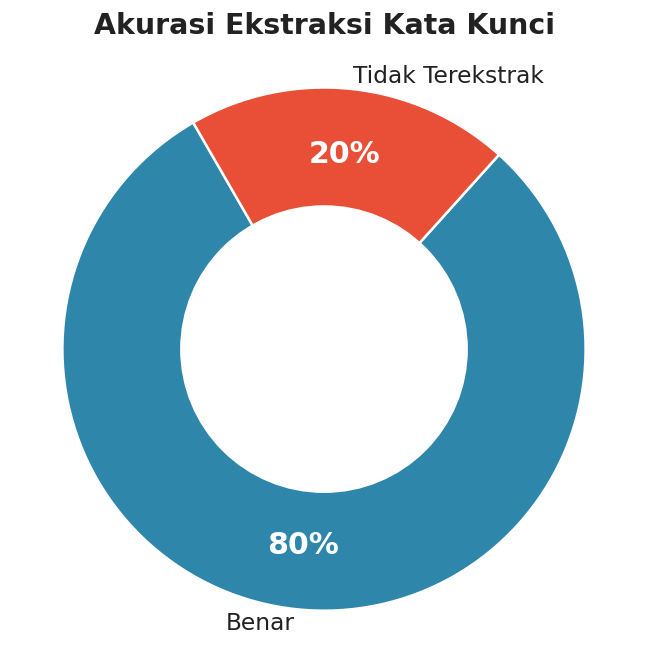

In [ ]:
# --- Sel Evaluasi Akurasi ---
import os # Diperlukan jika belum diimpor di atas atau jika kernel di-restart
import json # Diperlukan jika belum diimpor di atas atau jika kernel di-restart
try:
    from SaranaModule.evaluasi_akurasi import load_json_data, compare_results, assign_heuristic_scores, prepare_roc_data
    from SaranaModule.pengekstrak_kata_kunci import DAFTAR_KATA_KUNCI_KEUANGAN_DEFAULT
    print("Fungsi evaluasi dan konfigurasi kata kunci berhasil diimpor.")
except ImportError as e_import:
    print(f"Gagal mengimpor modul evaluasi atau konfigurasi: {e_import}. Pastikan file .py terkait ada dan benar.")
    # Definisikan fungsi dummy jika impor gagal
    def load_json_data(path): print("load_json_data tidak terdefinisi karena error impor."); return None
    def compare_results(data, path): print("compare_results tidak terdefinisi karena error impor."); return {}
    def assign_heuristic_scores(item, kw_config): print("assign_heuristic_scores tidak terdefinisi karena error impor."); return []
    def prepare_roc_data(items, gt_dir): print("prepare_roc_data tidak terdefinisi karena error impor."); return {'roc_points': [], 'auc': 0.0}
    DAFTAR_KATA_KUNCI_KEUANGAN_DEFAULT = [] # Dummy

# Menggunakan nama_file_json_output dari sel konfigurasi untuk path hasil ekstraksi
path_hasil_ekstraksi = "Output/Sarana/" + (nama_file_json_output if 'nama_file_json_output' in locals() and nama_file_json_output else "hasil_ekstraksi_semua_dokumen.json")
direktori_ground_truth = "train_documents/ground_truth/"

print(f"Mencoba memuat hasil ekstraksi dari: {path_hasil_ekstraksi}")
data_ekstraksi_semua = load_json_data(path_hasil_ekstraksi)

if data_ekstraksi_semua is not None:
    print(f"Berhasil memuat {len(data_ekstraksi_semua) if isinstance(data_ekstraksi_semua, list) else 0} entri dari hasil ekstraksi.")
    # Pastikan data_ekstraksi_semua adalah list, sesuai output notebook
    if not isinstance(data_ekstraksi_semua, list):
        print(f"Peringatan: data_ekstraksi_semua dari {path_hasil_ekstraksi} bukan merupakan list, melainkan {type(data_ekstraksi_semua)}. Fungsi compare_results mungkin tidak berjalan dengan benar.")
        # Jika ini adalah dict tunggal karena hanya satu file diproses dan JSON-nya adalah dict, bungkus dalam list
        # Namun, berdasarkan modifikasi notebook, ini seharusnya selalu list.
        # Jika ada error seperti KONFIGURASI_ERROR, data_ekstraksi_semua bisa jadi list berisi satu dict error.
        if isinstance(data_ekstraksi_semua, dict) and "nama_file" not in data_ekstraksi_semua:
             print("   Format tidak terduga, tidak terlihat seperti list hasil ekstraksi. Evaluasi mungkin tidak akurat.")

    print(f"Memulai evaluasi dengan direktori ground truth: {direktori_ground_truth}")
    hasil_evaluasi = compare_results(data_ekstraksi_semua, direktori_ground_truth)
    
    print("\n--- Hasil Evaluasi Akurasi ---")
    if hasil_evaluasi and 'overall_aggregate_accuracy' in hasil_evaluasi:
        overall_metrics = hasil_evaluasi['overall_aggregate_accuracy']
        accuracy_percentage = overall_metrics.get('accuracy_percentage', 'N/A')
        total_gt_keywords = overall_metrics.get('total_ground_truth_keywords', 'N/A')
        total_correctly_extracted = overall_metrics.get('total_correctly_extracted_with_correct_values', 'N/A')

        if isinstance(accuracy_percentage, float):
            print(f"  Persentase Akurasi Agregat Keseluruhan: {accuracy_percentage:.2f}%")
        else:
            print(f"  Persentase Akurasi Agregat Keseluruhan: {accuracy_percentage}")
        
        print(f"  Total Kata Kunci Ground Truth: {total_gt_keywords}")
        print(f"  Total Kata Kunci Diekstrak dengan Benar (Nilai Cocok): {total_correctly_extracted}")

    else:
        print("Tidak dapat menemukan data akurasi agregat keseluruhan dalam hasil evaluasi.")

else:
    print(f"Gagal memuat hasil ekstraksi dari '{path_hasil_ekstraksi}'. Evaluasi tidak dapat dilanjutkan.")

# --- Pie Chart Minimalis Elegan untuk Pitch Deck ---
import matplotlib.pyplot as plt

# Data untuk pie chart
if isinstance(total_gt_keywords, (int, float)) and isinstance(total_correctly_extracted, (int, float)):
    total_missed_keywords = total_gt_keywords - total_correctly_extracted

    labels = ['Benar', 'Tidak Terekstrak']
    sizes = [total_correctly_extracted, total_missed_keywords]
    colors = ['#2E86AB', '#E94F37']  # Biru elegan & merah modern

    fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=120)
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct=lambda pct: f"{pct:.0f}%" if pct > 0 else "",
        startangle=120,
        colors=colors,
        pctdistance=0.75,
        labeldistance=1.05,
        wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'},
        textprops={'fontsize': 13, 'color': '#222'}
    )

    # Styling teks
    plt.setp(autotexts, size=18, weight='bold', color='white')
    plt.setp(texts, size=14, weight='medium')

    # Tambahkan lingkaran tengah agar tampak seperti donut chart (lebih modern)
    centre_circle = plt.Circle((0, 0), 0.55, fc='white', linewidth=0)
    fig.gca().add_artist(centre_circle)

    # Judul minimalis
    plt.title('Akurasi Ekstraksi Kata Kunci', fontsize=17, fontweight='bold', color='#222', pad=18)

    # Hilangkan axis dan border
    ax.axis('equal')
    plt.box(False)
    plt.tight_layout()
    plt.show()
else:
    print("Error: 'total_gt_keywords' atau 'total_correctly_extracted' bukan angka valid. Pie chart tidak dapat dibuat.")
# --- End Pie Chart Minimalis Elegan ---


## Catatan Akhir: Efisiensi, Keterbatasan, dan Pengembangan Lanjutan

Notebook ini menyediakan alur kerja yang komprehensif untuk parsing dokumen dan ekstraksi informasi keuangan dasar. Namun, ada beberapa hal yang perlu diperhatikan:

*   **Efisiensi Pemrosesan**:
    *   **PDF Besar**: Seperti yang disebutkan, PDF besar dengan banyak halaman gambar bisa lambat karena OCR. Fitur **OCR Paralel** yang diimplementasikan di `parser_pdf.py` membantu mengurangi waktu tunggu.
    *   **Caching**: Mekanisme **caching** untuk `parser_pdf.py` (disimpan di `.cache_parser_dokumen` secara default) akan sangat membantu jika Anda sering memproses ulang dokumen yang sama, karena hasil parsing akan diambil dari cache jika file tidak berubah.
    *   **Pra-pemrosesan Gambar**: Langkah ini penting untuk akurasi OCR, tetapi juga menambah waktu pemrosesan untuk setiap gambar/halaman gambar.

*   **Akurasi Ekstraksi Kata Kunci dan Nilai**:
    *   **Logika Tahun Terbaru**: `pengekstrak_kata_kunci.py` kini mencoba mengidentifikasi tahun pelaporan dan memprioritaskan nilai yang berasosiasi dengan tahun tersebut, serta membedakannya dari nilai tahun sebelumnya. Akurasi logika ini sangat bergantung pada konsistensi format tabel dan layout dalam dokumen. Mungkin memerlukan penyesuaian regex lebih lanjut untuk berbagai format laporan keuangan.
    *   **Variasi Kata Kunci**: Keberhasilan ekstraksi juga bergantung pada seberapa komprehensif daftar `variasi` untuk setiap `kata_dasar` dalam `konfigurasi_kata_kunci_target`.
    *   **Normalisasi Nilai**: Fungsi `normalisasi_nilai_keuangan` menangani format umum Indonesia, tetapi format yang sangat tidak standar mungkin memerlukan penyesuaian.
    *   **Konteks**: Ekstraktor saat ini menggunakan konteks kalimat dan kedekatan dengan tahun. Untuk kasus yang sangat ambigu, pemahaman struktur tabel atau elemen visual mungkin diperlukan (di luar cakupan saat ini).

*   **Keterbatasan Bahasa Indonesia di NLTK**:
    *   **Stopwords**: `pengekstrak_kata_kunci.py` mencoba menggunakan stopwords Bahasa Indonesia dari NLTK. Pastikan resource ini terinstal (`nltk.download('stopwords')`).
    *   **Lemmatization/Stemming**: `WordNetLemmatizer` NLTK tidak dioptimalkan untuk Bahasa Indonesia. Untuk hasil yang lebih baik dalam normalisasi kata, pertimbangkan untuk mengintegrasikan stemmer khusus Bahasa Indonesia seperti PySastrawi (memerlukan instalasi terpisah). Saat ini, keakuratan pencocokan lebih bergantung pada variasi eksplisit yang disediakan.

*   **Pengembangan Lanjutan yang Mungkin Dilakukan**:
    *   Integrasi stemmer Bahasa Indonesia.
    *   Pengembangan logika yang lebih canggih untuk memahami struktur tabel dalam dokumen.
    *   Pelatihan model Machine Learning kustom untuk klasifikasi teks atau Named Entity Recognition (NER) pada dokumen keuangan untuk identifikasi entitas dan nilai yang lebih robust.
    *   Antarmuka pengguna grafis (GUI) atau aplikasi web di atas logika ini.
